In [16]:
import numpy as np
import scipy.io
import pickle
from math import floor
import matplotlib.pyplot as plt
from stablab import (semicirc, winding_number, Evans_plot, emcset,
                       Evans_compute, Struct, reflect_image)
from stablab.wave_profile import profile_flux, soln
from stablab.root_finding import moments_roots
from stablab.evans import LdimRdim
from stablab.contour import Evans_plot_mult

In [17]:
from MHD2 import profile_ode, profile_jacobian
from MHD2 import A_evans, A_lop, A_jump, Ak

In [18]:
from mpl_toolkits import mplot3d

In [19]:
from run_line_MHD2 import find_roots

In [20]:
np.set_printoptions(suppress=True)

In [6]:
%matplotlib notebook

In [14]:
np.linspace(1e-6,1e-4,10)

array([0.000001, 0.000012, 0.000023, 0.000034, 0.000045, 0.000056,
       0.000067, 0.000078, 0.000089, 0.0001  ])

In [7]:
h1_vals = np.linspace(1.399,1.415,5)
xi_vals = [1e-4,1e-5,1e-6]
u_plus = .8
d = find_roots(h1_vals,u_plus,xi_vals)

1.399 0.0001
1.399 1e-05
(11, 9) -1 0
	 did not work
1.399 1e-06
(11, 12) -1 0
	 did not work
1.403 0.0001
1.403 1e-05
(11, 13) -1 0
	 did not work
1.403 1e-06
(11, 12) -1 0
	 did not work
1.407 0.0001
1.407 1e-05
1.407 1e-06
(11, 12) -1 0
	 did not work
1.411 0.0001
1.411 1e-05
(11, 10) -1 0
	 did not work
1.411 1e-06
1.415 0.0001
1.415 1e-05
1.415 1e-06


In [11]:
plt.rcParams['figure.figsize'] = 5,5

In [12]:
h1_vals = list(np.linspace(1.399,1.415,5))
xi_vals = [1e-4,1e-5,1e-6]

roots = np.zeros((5,3))

for h1 in d.keys():
    x_ind = h1_vals.index(h1)
    for xi in d[h1].keys():
        y_ind = xi_vals.index(xi)
        if d[h1][xi][1]:
            roots[x_ind,y_ind] = d[h1][xi][0]

<IPython.core.display.Javascript object>


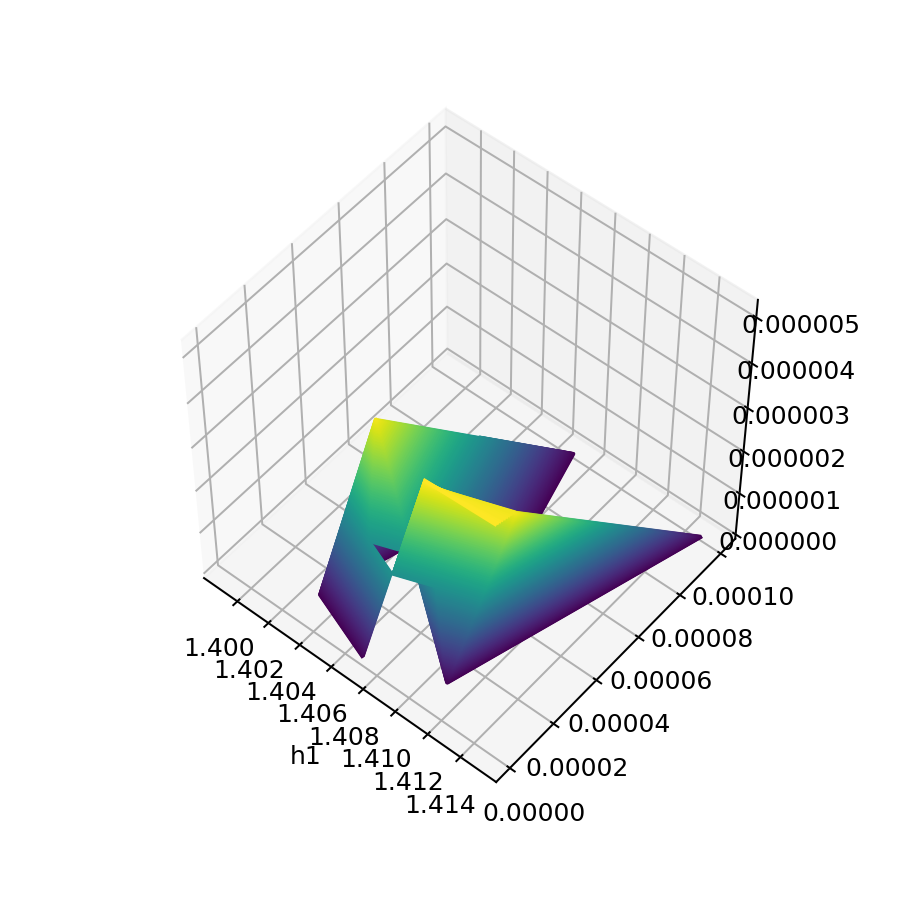

In [13]:
X,Y = np.meshgrid(h1_vals,xi_vals)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X,Y,roots.T,500)
plt.xlabel('h1')
plt.show()

# Initialize Parameters

In [21]:
# Parameters
def setParams():
    p = Struct({'h1': 3.75,
            'Gamma': Gamma, 
            'v_plus': .99,
            'mu': .1,
            'eta': -2/3*mu,
            'cnu': cnu,
            'R': cnu*Gamma,
            'alpha':1,
            'kappa': .1 })
    p.update({
            'v_star': p['Gamma']/(p['Gamma']+2) # 3.14
            })
    p.update({
            'e_plus': p['v_plus']*(p['Gamma']+2-p['Gamma']*p['v_plus'])/(2*p['Gamma']*(p['Gamma']+1)), # 3.15
            'e_minus': (p['Gamma']+2)*(p['v_plus']-p['v_star'])/(2*p['Gamma']*(p['Gamma']+1)), # 3.16
            'v_minus': 1,
            'nu': p['kappa']/p['cnu'] # see below 2.25
            })
    p.update({
            'UR': [1/p['v_plus'],p['v_plus'],0,p['h1'],0,p['e_plus']/p['cnu']],
            'UL': [1/p['v_minus'],p['v_minus'],0,p['h1'],0,p['e_minus']/p['cnu']]
            })
    return p

# Inputs
# L = 10
# X_STEPS = 200
Gamma = 2/3#.666 # for 2/3 winding num = 1
cnu = 1
mu = .1
p = setParams()

# Initialising sol, the Struct with solution values
sol = Struct({
    'n': 2, # this is the dimension of the profile ode
    # we divide the domain in half to deal with the
    # non-uniqueness caused by translational invariance
    # sol.side = 1 means we are solving the profile on the interval [0,X]
    'side': 1,
    'F': profile_ode, # F is the profile ode
    'Flinear': profile_jacobian, # J is the profile ode Jacobian
    'UL': np.array([p['v_minus'],p['e_minus']]), # These are the endstates of the profile and its derivative at x = -infty
    'UR': np.array([p['v_plus'],p['e_plus']]), # These are the endstates of the profile and its derivative at x = +infty
    'tol': 1e-7,
    'xi': 1,
    'system' : 'parallel',
    'mat_type' : 'mbfv',
    'tol':1e-5
    })
sol.update({
    'phase': 0.5*(sol['UL']+sol['UR']), # this is the phase condition for the profile at x = 0
    'order': [1], # this indicates to which component the phase conditions is applied
    'stats': 'on', # this prints data and plots the profile as it is solved
    'bvp_options': {'Tol': 1e-8, 'Nmax': 20000},
    'L_max': 10000,
    'R_max': 10000
    })

# Solve Profile

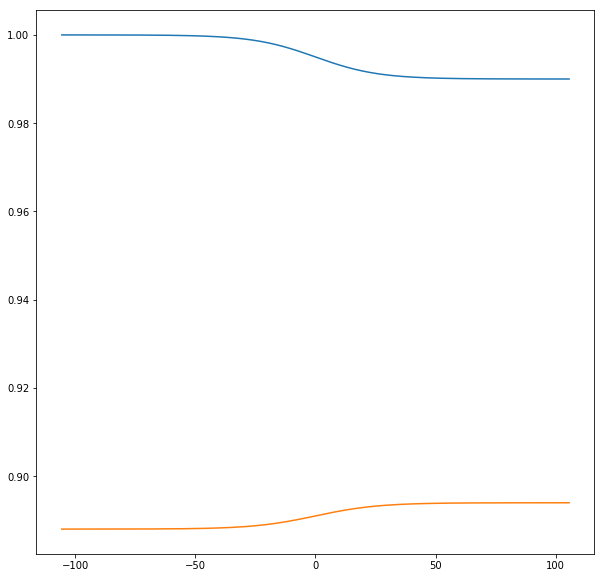

In [22]:
# Solve the profile
sol['stats'] = 'off'
p, s_org = profile_flux(p, sol)

# Plot the profile
x = np.linspace(s_org['L'],s_org['R'],200)
y = soln(x,s_org)

plt.figure("Profile")
plt.plot(x,y)
plt.show()

# Evaluate Evans Function

In [23]:
# Set up Stablab structures
# s, e, m, c = emcset(s,'front',[5,6],'reg_reg_polar',A)
try:
    Ldim,Rdim = LdimRdim(A_evans, s_org, p)
except:
    Ldim, Rdim = 5,6
s, e, m, c = emcset(s_org,'front',[Ldim,Rdim],'default',A_evans)

m['options'] = {}
m['options']['RelTol'] = 1e-10
m['options']['AbsTol'] = 1e-12

# refine the Evans function computation to achieve set relative error
c['refine'] = 'off';

s['xi'] = 5e-5

# display a waitbar
c['stats'] = 'print'
# c['stats'] = 'on'
c['ksteps'] = 2**8
c['lambda_steps'] = 0

c['tol'] = 0.01
c['check'] = 'off'
c['parallel'] = 'off'

r = 1e-12
R = 1e-4
pnts = 30
preimage = np.linspace(R,r,pnts+(pnts-1)*c['ksteps'])
# Compute the Evans function
out, domain = Evans_compute(preimage,c,s,p,m,e)

# Normalize and plot the Evans function
out = out/out[0]

Finding the kato basis


/Users/bryn/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: problem is probably stiff (interrupted)
  self.messages.get(istate, unexpected_istate_msg)))


29


/Users/bryn/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


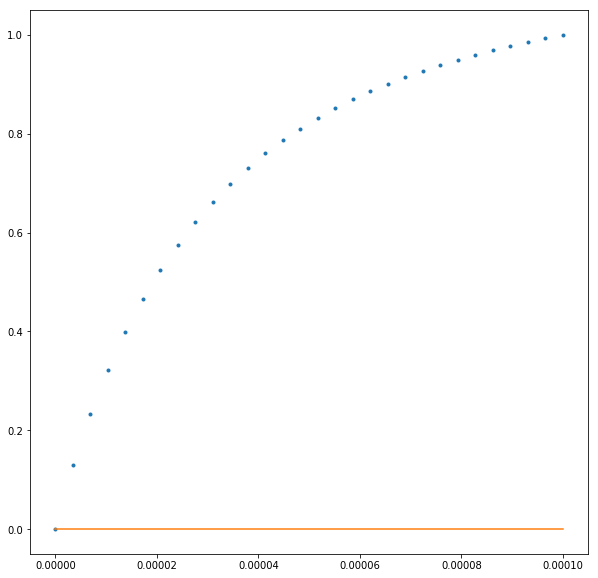

In [25]:
loc,success = get_root(domain,out)

plt.plot(domain,out,'.')

if success:
    plt.plot(loc,0,'o')
    
plt.plot([domain[0],domain[-1]],[0,0])
plt.show()

In [135]:
out[-1]

(-0.0002787207472022705-3.224536472901231e-12j)

In [136]:
loc,success = get_root(domain,out)

29
0 14 29
14 14 29
15
14 21 29
21 21 29
8
21 25 29
25 25 29
4
25 27 29
27 27 29
2
27 28 29
28 28 29
1


In [24]:
def get_root(d,o):
    l_ind = 0
    r_ind = len(o)-1
    
    count = 0
    while True:
        count += 1
        print(r_ind-l_ind)
        if np.real(o[l_ind])*np.real(o[r_ind]) > 0:
            found_root = False
            break
            
        if abs(l_ind-r_ind) == 1:
            found_root = True
            break
        
        new_ind = floor((r_ind+l_ind)/2)
        print(l_ind,new_ind,r_ind)
        if np.real(o[l_ind])*np.real(o[new_ind]) > 0:
            l_ind = new_ind
        else:
            r_ind = new_ind
            
        print(l_ind,new_ind,r_ind)
            
        if count == 10: break
            
    l_val = np.real(o[l_ind])
    r_val = np.real(o[r_ind])
    
    l_dom = d[l_ind]
    r_dom = d[r_ind]
    
    x_val = l_dom - l_val * (r_dom-l_dom)/(r_val-l_val)
    
    return x_val, found_root
    
    if abs(np.real(l_val)) < abs(np.real(r_val)):
        return d[l_ind], l_val, found_root
    else:
        return d[r_ind], r_val, found_root

In [7]:
# # syntax for comparing code to matlab output
# U1_py = np.load('U1.npy')
# U1_ml = scipy.io.loadmat('check.mat')['US']
# print(U1_py.shape)
# print(U1_ml.shape)
# print(np.linalg.norm(U1_py-U1_ml))

In [8]:
evans_w = w.copy()

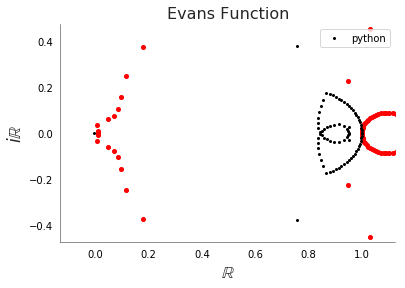

4.524536169994575


In [9]:
matlab_w = scipy.io.loadmat('evan_18_85.mat')['tosave']
Evans_plot_mult(evans_w,matlab_w,titlestring='Evans Function',figname='compare_evans_18_85.png')
print(np.linalg.norm(matlab_w-evans_w))

# Evaluate Lopatinski Determinant

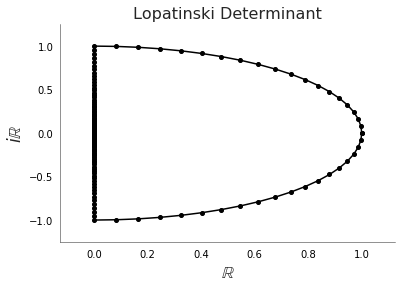

Winding Number: 0.000000

Roots: []



In [16]:
# Set up Stablab structures
# s, e, m, c = emcset(s,'front',[5,6],'reg_reg_polar',A)
Ldim,Rdim = LdimRdim(A_lop, s_org, p)
s, e, m, c = emcset(s_org,'lopatinski',[Ldim,Rdim],'default',A_lop)

# set the lopatinski jump condition
e['jump'] = A_jump

s['xi'] = 1
s['R'] = 1
s['L'] = -1

# refine the Evans function computation to achieve set relative error
c['refine'] = 'off';

# display a waitbar
# c['stats'] = 'print'
# c['stats'] = 'on'
c['ksteps'] = 2**8

c['tol'] = 0.1

# Set up the preimage
circpnts, imagpnts, innerpnts = 20, 80, 32
r = 100
shift = 1e-5
spread = 4
zerodist = 0#10**(-4)
# ksteps, lambda_steps = 32, 0
preimage = semicirc(circpnts, imagpnts, c['ksteps'], r, spread, zerodist)+shift

# Compute the Evans function
out0, domain = Evans_compute(preimage,c,s,p,m,e)

# Normalize and plot the Evans function
out = out0/out0[0]
w = reflect_image(out)
prew = reflect_image(domain)
Evans_plot(w,titlestring='Lopatinski Determinant')

windnum = winding_number(w)
print('Winding Number: {:f}\n'.format(windnum))

rts = moments_roots(prew,w).real
print('Roots: {}\n'.format(rts))

In [11]:
lop_w = w.copy()

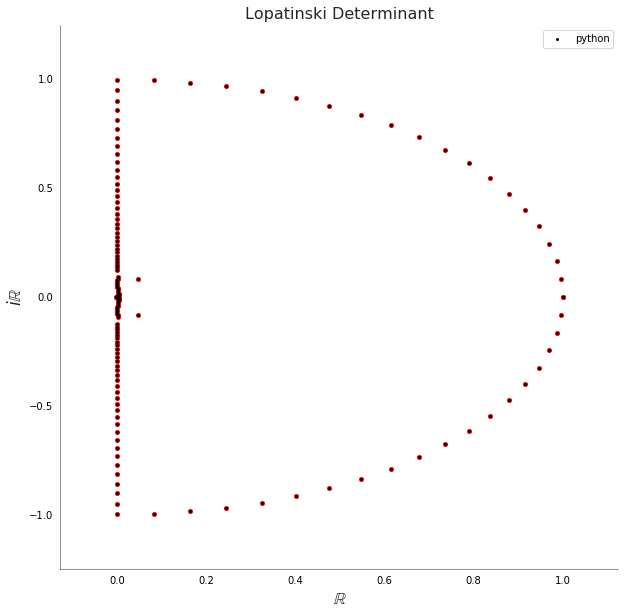

2.2583629705836033e-12


In [21]:
matlab_w = scipy.io.loadmat('lop_14_8.mat')['tosave']
Evans_plot_mult(lop_w,matlab_w,titlestring='Lopatinski Determinant',figname='compare_evans_18_85.png')
print(np.linalg.norm(matlab_w-lop_w))

In [15]:
def fill_dictionary(d,h1_vals,vp_vals,output):
    # loop through h1vp pairs
    for h1vp in output.keys():
        h1,vp = h1vp.split()
        h1,vp = float(h1),float(vp)
        
        if h1 == 1.01: h1 = 1
        if vp == .99: vp = 1
#         print(h1)

        # get h1 and vp
        h1_vals.append(h1)
        vp_vals.append(vp)

        # get lop winding number
        lop_d = output[h1vp]['lop']
        if lop_d is not None:
            lop_wnd = lop_d['wnd']
        else:
            lop_wnd = None

        # get evans winding number
        evn_d = output[h1vp]['evans']
        if evn_d is not None:
            evn_wnd = evn_d['wnd']
        else:
            evn_wnd = None
            
        if evn_wnd != None and lop_wnd != None:
            if lop_wnd == 0 and evn_wnd > 0:
#                 print(evn_d['xi'])
                xi = round(evn_d['xi'],10)
                R = lop_d['R']
                print(h1,vp,evn_wnd,xi,lop_wnd,R,sep='\t')

        # store winding numbers
        wnd_nums = [lop_wnd,evn_wnd]
        if h1 in d.keys():
            d[h1][vp] = wnd_nums
        else:
            d[h1] = {vp:wnd_nums}
            
#     print(set(h1_vals))
    return d, h1_vals,vp_vals

In [26]:
def view_batch_results(b_num):
    
    print('h1\tvp\tEvans\txi\tLop\tR')
    # new dictionary
    d = {}

    # storage for h1 and vp
    h1_vals = []
    vp_vals = []
    
    if isinstance(b_num,list):
        for bn in b_num:
            filename = 'output/batch{}.pkl'.format(bn)
            load = pickle.load(open(filename,'rb'))
            d, h1_vals, vp_vals = fill_dictionary(d,h1_vals,vp_vals,load)
    else:
        filename = 'output/batch{}.pkl'.format(b_num)
        load = pickle.load(open(filename,'rb'))
        d, h1_vals, vp_vals = fill_dictionary(d,h1_vals,vp_vals,load)

    # remove duplicate h1,vp values
    h1_vals = list(set(h1_vals))
    vp_vals = list(set(vp_vals))
    
    fig = plt.figure()
    
    plt.rcParams['figure.figsize'] = 12,5
    
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0],marker='o', color='w',markerfacecolor='lightsteelblue'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='C0'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='lightgreen'),
                    Line2D([0], [0],marker='o', color='w',markerfacecolor='C2')]

#     plt.subplot(121)
    for h1 in h1_vals:
        for vp in vp_vals:
#             if d[h1][vp][0] == 0 and d[h1][vp][1] == 1:
#                 print(h1,vp)
            try:
                wnd = d[h1][vp][0]
                if wnd == 0:
                    plt.plot(vp-.002,h1,'.',color='lightsteelblue')
                elif wnd == 1:
                    plt.plot(vp-.002,h1,'.C0')
            except:
                plt.plot(vp-.002,h1,'.C1')
#                 print(h1,vp,'no lopatinski winding number')
    plt.title('Lopatinski Winding Numbers')
    plt.xlabel(r'$u_+$')
    plt.ylabel(r'$h_1$')

#     plt.subplot(122)
    for h1 in h1_vals:
        for vp in vp_vals:
            try:
                wnd = d[h1][vp][1]
                if wnd == 0:
                    plt.plot(vp+.002,h1,'.',color='lightgreen')
                elif wnd == 1:
                    plt.plot(vp+.002,h1,'.C2')
            except:
                plt.plot(vp+.002,h1,'.C1')
#                 print(h1,vp,'no evans winding number')
    plt.title('Stability Comparison')
    plt.xlabel(r'$u_+$')
    plt.ylabel(r'$h_1$')
    
    legend_x = 1
    legend_y = 0.5
#     plt.rcParams['figure.figsize'] = 15,10
    plt.legend(custom_lines, ['Stable Inviscid','Unstable Inviscid','Stable Viscous','Unstable Viscous'], loc='center left', bbox_to_anchor=(legend_x, legend_y))
    
#     plt.xlim(0,.0101)
    plt.xlim(.59,1.01)
    plt.tight_layout()
    plt.savefig('stability.png',dpi=100)
    plt.show()

h1	vp	Evans	xi	Lop	R
1.4	0.8	1	0.0001	0	10
3.75	1	1	0.0001	0	10


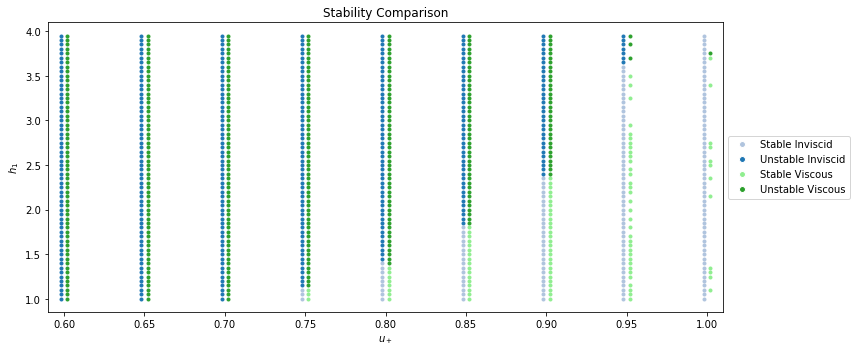

In [27]:
view_batch_results([0,1,2,3,4,5,6,7,8,9,10,11])

In [ ]:
D = {.75:[]}